In [ ]:
# Force Delete for non-empty dirs
import shutil
import os

folder_path = '/content/dataset'

# Check if the folder exists
if os.path.exists(folder_path):
    # Force delete the folder
    shutil.rmtree(folder_path)
    print(f'Folder {folder_path} has been deleted.')
else:
    print(f'Folder {folder_path} does not exist.')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set Up  Kaggle  and Download Dataset
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d jangedoo/utkface-new

# Unzip the dataset
!unzip utkface-new.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: /content/dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  in

In [3]:
# Extract and save features from images to csv to optimize data loading and processing
import os
import pandas as pd
import tensorflow as tf
from datetime import datetime
import numpy as np
import base64
import random

data_path = '/content/dataset/UTKFace'

# for google drive based dataset

# move dataset to google drive
# !cp -r /content/dataset /content/drive/MyDrive/zonecam/UTKFace

# data_path = '/content/drive/MyDrive/zonecam/UTKFace'



data = []


for filename in os.listdir(data_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        try:

          # Extract information from the filename
          parts = filename.split('_')

          if len(parts) == 4:
              age, gender, race, dt = parts
          elif len(parts) == 3:
              age, gender, dt = parts
              race = 0

          image_path = os.path.join(data_path, filename)

          data.append({
              "image_path": image_path,
              'age': int(age),
              'gender': int(gender),
              'race': int(race),
          })
        except Exception as e:
          print("Error at file: ", filename)
          print(e)
          break


df = pd.DataFrame(data)

# Save to CSV on drive
output_path = '/content/data.csv'
df.to_csv(output_path, index=False)

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Add,Dense, Conv2D, Reshape, Dropout, Flatten, Concatenate, Input, BatchNormalization, Conv1D, MaxPooling2D,  MaxPooling1D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 5

In [5]:
# Load dataset
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    return df

def preprocess_image(img_path):
    try:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
    except tf.errors.InvalidArgumentError:
        print(f"Error reading or decoding image file: {img_path}")
        return None

    img = tf.image.resize(img, IMG_SIZE)

    # Normalize image values to have a mean of 0 and a standard deviation of 1
    img = tf.image.per_image_standardization(img)

    # Optional: Add random data augmentation
    img = tf.image.random_flip_left_right(img)

    return img

# Prepare dataset for training
def prepare_dataset(df, batch_size):
    image_paths = df['image_path'].values
    ages = df['age'].values
    genders = df['gender'].values
    races = df['race'].values

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, ages, genders, races))

    def load_and_preprocess_image(image_path, age, gender, race):
        image = preprocess_image(image_path)
        return (image, age, gender), race

    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).repeat()

    return dataset

                                          image_path  age  gender  race
0  /content/dataset/UTKFace/51_0_1_20170111200729...   51       0     1
1  /content/dataset/UTKFace/56_1_0_20170109132244...   56       1     0
2  /content/dataset/UTKFace/2_0_2_201612191921506...    2       0     2
3  /content/dataset/UTKFace/66_1_0_20170110132123...   66       1     0
4  /content/dataset/UTKFace/61_0_3_20170109150814...   61       0     3
                age        gender          race
count  23708.000000  23708.000000  23708.000000
mean      33.303484      0.477349      1.269065
std       19.886112      0.499497      1.345628
min        1.000000      0.000000      0.000000
25%       23.000000      0.000000      0.000000
50%       29.000000      0.000000      1.000000
75%       45.000000      1.000000      2.000000
max      116.000000      1.000000      4.000000
image_path    0
age           0
gender        0
race          0
dtype: int64


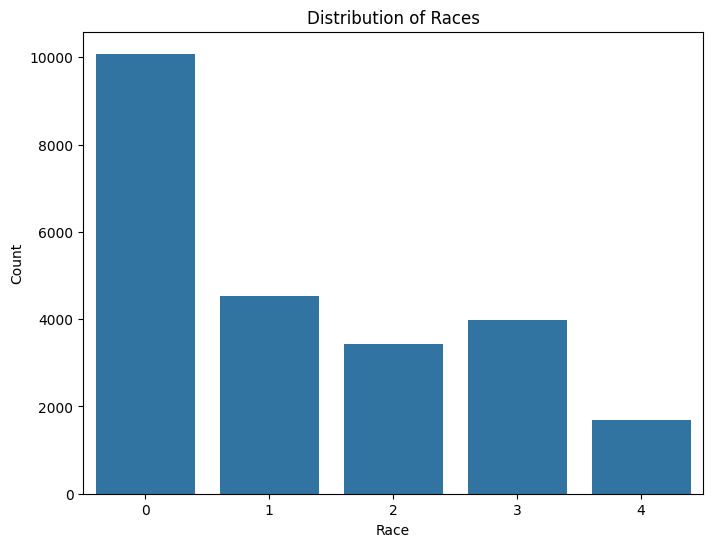

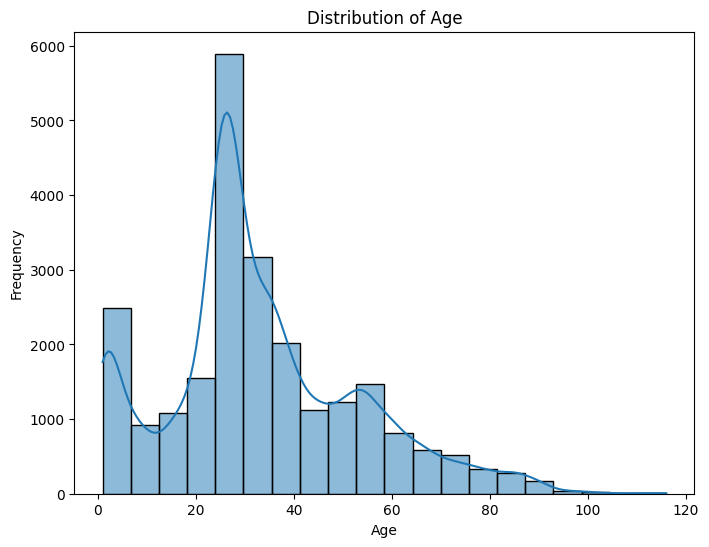

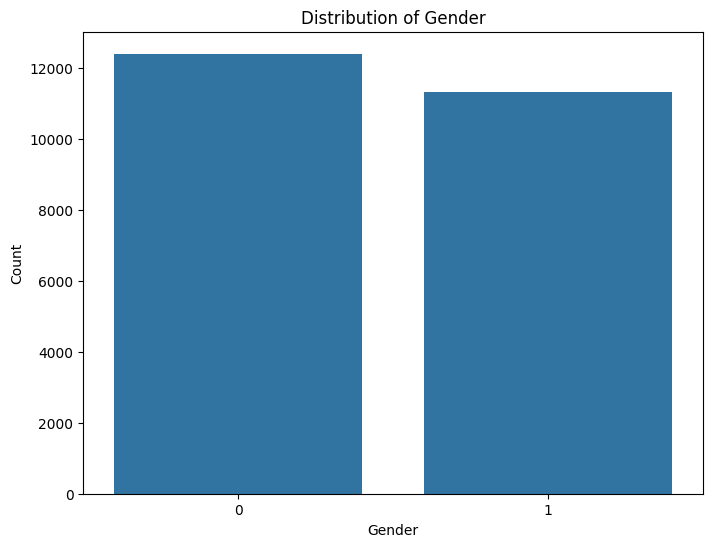

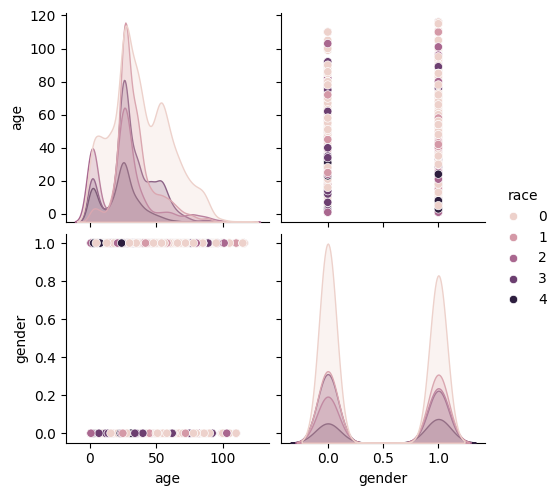

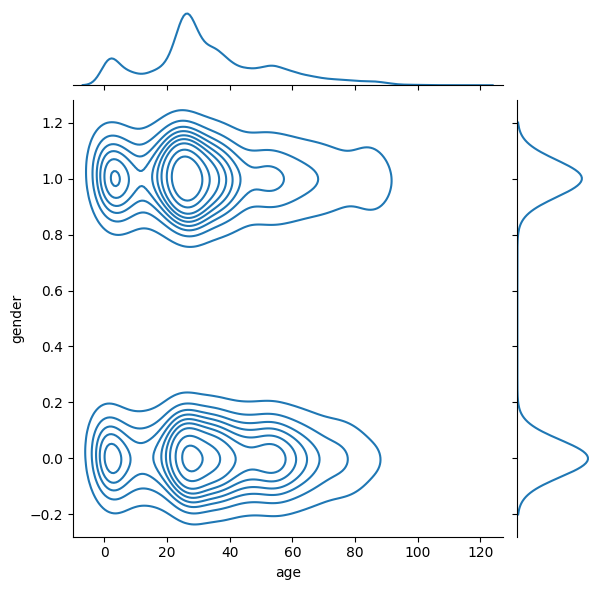

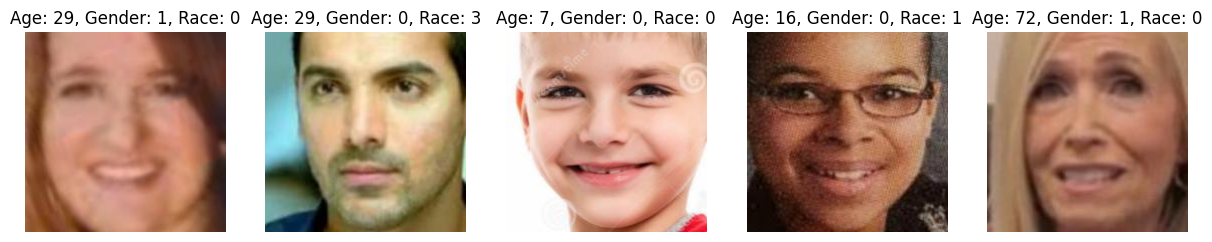

In [6]:
# Load and preprocess data
csv_path = '/content/data.csv'
df = load_data(csv_path)


# Display the first few rows
print(df.head())

# Display basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of races
plt.figure(figsize=(8, 6))
sns.countplot(x='race', data=df)
plt.title('Distribution of Races')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

# Distribution of age
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


# Pair plot for age, gender, and race
sns.pairplot(df, hue='race', vars=['age', 'gender'])
plt.show()

# Joint distribution of age and gender
sns.jointplot(x='age', y='gender', data=df, kind='kde')
plt.show()


import matplotlib.pyplot as plt
import cv2
import random

# display a random image sample
def display_random_images(df, data_path, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        random_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[random_idx]['image_path']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Age: {df.iloc[random_idx]['age']}, Gender: {df.iloc[random_idx]['gender']}, Race: {df.iloc[random_idx]['race']}")
        plt.axis('off')

    plt.show()

# Display 5 sample image
display_random_images(df, '/content/dataset/UTKFace', num_images=5)


In [7]:


# Split into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['race'])
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['race'])

# Create datasets
train_dataset = prepare_dataset(train_df, BATCH_SIZE)
valid_dataset = prepare_dataset(valid_df, BATCH_SIZE)
test_dataset = prepare_dataset(test_df, BATCH_SIZE)

# Define the custom convolutional neural network
NUM_CLASSES = 5  # Number of classes

input_layer = Input(shape=(224, 224, 3))

conv1 = Conv2D(64, kernel_size=3, activation='relu')(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = MaxPooling2D(pool_size=2)(conv1)

conv2 = Conv2D(128, kernel_size=3, activation='relu')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = MaxPooling2D(pool_size=2)(conv2)

conv3 = Conv2D(256, kernel_size=3, activation='relu')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = MaxPooling2D(pool_size=2)(conv3)

conv4 = Conv2D(512, kernel_size=3, activation='relu')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = MaxPooling2D(pool_size=2)(conv4)

conv5 = Conv2D(1024, kernel_size=3, activation='relu')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = MaxPooling2D(pool_size=2)(conv5)

x = Flatten()(conv5)

# Additional inputs
age_input = Input(shape=(1,), name='age')
gender_input = Input(shape=(1,), name='gender')

# Concatenate inputs
concat = Concatenate()([x, age_input, gender_input])

concat = Reshape((-1,1))(concat)

# Dense layers
x = Flatten()(concat)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=[input_layer, age_input, gender_input], outputs=x)

In [9]:
# Model definition
model = Model(inputs=[input_layer, age_input, gender_input], outputs=x)

# Define optimizers

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.001)
nadam = Nadam(learning_rate=0.002)

# early stopping callback and checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/zonecam/model_1.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Compile the model
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(train_df) // BATCH_SIZE,
          validation_data=valid_dataset, validation_steps=len(valid_df) // BATCH_SIZE, callbacks=[early_stopping, model_checkpoint])




Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 154s 417ms/step - accuracy: 0.4211 - loss: 1.7522 - val_accuracy: 0.6453 - val_loss: 0.9447
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 113s 326ms/step - accuracy: 0.6255 - loss: 1.0694 - val_accuracy: 0.6909 - val_loss: 0.8335
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 93s 313ms/step - accuracy: 0.6866 - loss: 0.9017 - val_accuracy: 0.7629 - val_loss: 0.6769
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 93s 314ms/step - accuracy: 0.7251 - loss: 0.8051 - val_accuracy: 0.7785 - val_loss: 0.6358
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 94s 316ms/step - accuracy: 0.7535 - loss: 0.7312 - val_accuracy: 0.7997 - val_loss: 0.5913
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 88s 297ms/step - accuracy: 0.7734 - loss: 0.6718 - val_accuracy: 0.7742 - val_loss: 0.6535
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 88s 297ms/step - accuracy: 0.7877 - loss: 0.6350 - val_accuracy: 0.7950 - val_loss: 0.6034
Epoch 8/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 88s 297ms/step - accuracy: 0.7970 - loss:

In [11]:
# Evaluate the model on the test data

num_test_samples = len(test_df)
test_steps = num_test_samples // BATCH_SIZE
test_loss, test_acc = model.evaluate(test_dataset, steps=test_steps)
print('Test accuracy:', test_acc)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8073 - loss: 0.7024
Test accuracy: 0.802787184715271
